# Projekt 2
Projekt przygotowany z:
- Python 3.7
- Jupyter labs
- Virtual Environment

Wykorzystane biblioteki:
- pandas
- seaborn
- numpy
- sklearn
- matplotlib

Repozytorium z kodem: [Github](https://github.com/Isur/keras-training)

Grupa projektowa:
- Artur Bednarczyk
- Krzysztof Janiec
- Filip Strózik

# Instalacja z Repozytorium
## Środowisko Wirtualne
### Tworzenie
Linux: `python3.7 -m venv venv`

Windows: `py -m venv venv`
### Aktywacja
Linux: `source ./venv/bin/activate`

Windows: `.\venv\Scripts\activate`
## Instalacja paczek
`pip install -r req.txt`
## Struktura projektu
`venv` - folder środowiska wirtualnego

`docs` - jupyter notebooks, dokumentacja

`src` - pliki źródłowe

`req.txt` - zależności

`app.py` - plik wejściowy, do uruchomienia aplikacji

# Wino
## Dataset
> Wino – napój alkoholowy uzyskiwany w wyniku fermentacji moszczu winogronowego.
> Istnieje wiele rodzajów win, co związane jest z mnogością odmian winorośli, oddziaływaniem środowiska na ich wzrost i różnymi technikami winifikacji (przekształcania winogron w wino). Można wyróżnić wina białe, różowe i czerwone. Ze względu na zawartość cukru można je podzielić na wytrawne, półwytrawne, półsłodkie i słodkie. Mogą to być wina musujące lub niemusujące. Nauką zajmującą się produkcją wina jest enologia.[Wikipedia](https://pl.wikipedia.org/wiki/Wino)

Zbiór danych wykorzystany w tym projekcie to zbiór informacji o winie portugalskim "Vinho Verde" białym oraz czerwonym. Zbiór jest w formacie `csv`, posiada następujące kolumny:


|Lp.|Kolumna|Wyjaśnienie|
|---|-------|----------|
|1.|type|Typ wina - białe lub czerwone|
|2.|fixed acidity|kwasowość stała|
|3.|volatile acidity|kwasowość lotna|
|4.|citric acid|kwas cytrynowy|
|5.|residual sugar|cukier resztkowy|
|6.|chlorides|chlorki|
|7.|free sulfur dioxide|wolny dwutlenek siarki|
|8.|total sulfur dioxide|całkowity dwutlenek siarki|
|9.|density|gęstość|
|10.|pH|pH|
|11.|sulphates|siarczany|
|12.|alcohol|alkohol|
|13.|quality|jakość (0-10)|

## Przygotowanie
### Biblioteki
Zaczynamy od importowania wymaganych bibliotek oraz wyłączenia niepotrzebnych ostrzeżeń:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix as cm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Wczytanie danych
Do wczytania danych z pliku `csv` wykorzystujemy bibliotekę `pandas`.

In [2]:
dataset = pd.read_csv("winequalityN.csv")

### Przygotowanie danych
Zaczynamy od sprawdzenia czy dane są pełne, czy nie ma braków.

In [3]:
def show_nulls(dataset):
    Sum = dataset.isnull().sum()
    Percentage = (dataset.isnull().sum() / dataset.isnull().count())
    stat = pd.concat([Sum, Percentage], axis=1, keys=['Sum', 'Percentage'])
    print(stat)
    
show_nulls(dataset)

                      Sum  Percentage
type                    0    0.000000
fixed acidity          10    0.001539
volatile acidity        8    0.001231
citric acid             3    0.000462
residual sugar          2    0.000308
chlorides               2    0.000308
free sulfur dioxide     0    0.000000
total sulfur dioxide    0    0.000000
density                 0    0.000000
pH                      9    0.001385
sulphates               4    0.000616
alcohol                 0    0.000000
quality                 0    0.000000


Brakuje kilku danych, więc musimy je uzupełnić, zrobimy to uśredniając dane. Możemy to zrobić ponieważ odsetek pustych jest na tyle niski, że nie wpłynie to negatywnie na wyniki. Wszystkie operacje będziemy wykonywać na skopiowanych danych.

In [4]:
db = dataset
total_missing_values = db.isnull().sum()
missing_values_per = db.isnull().sum() / db.isnull().count()
null_values = pd.concat([total_missing_values, missing_values_per], axis=1,
                        keys=['total_null', 'total_null_perc'])
null_values = null_values.sort_values('total_null', ascending=False)

fill_list = null_values[null_values['total_null'] > 0].index
db_prepared = db.copy()
for col in fill_list:
    db_prepared.loc[:, col].fillna(db_prepared.loc[:, col].mean(), inplace=True)

Sprawdzany czy poprawnie zostało wszystko wypełnione.

In [5]:
show_nulls(db_prepared)

                      Sum  Percentage
type                    0         0.0
fixed acidity           0         0.0
volatile acidity        0         0.0
citric acid             0         0.0
residual sugar          0         0.0
chlorides               0         0.0
free sulfur dioxide     0         0.0
total sulfur dioxide    0         0.0
density                 0         0.0
pH                      0         0.0
sulphates               0         0.0
alcohol                 0         0.0
quality                 0         0.0


W celu ułatwienia klasyfikacji jakości win, zamiast oceny w skali do 10, podzielimy zbiór na wina o niskiej, średniej oraz wysokiej jakości.
Wina o jakości 4 i mniejszej oznaczamy jako `low`, do 7 `medium` oraz powyżej `high`.

In [6]:
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(db_prepared.type.values)
db_prepared['color'] = y_tp
db_prepared['quality_label'] = db_prepared.quality.apply(
    lambda q: 'low' if q <= 4 else 'medium' if q <= 7 else 'high')

## Analiza danych
### Rozkład typu i jakości
Po wypełnieniu danych możemy zobaczyć rozkład win w zależności od ich jakości i typu.

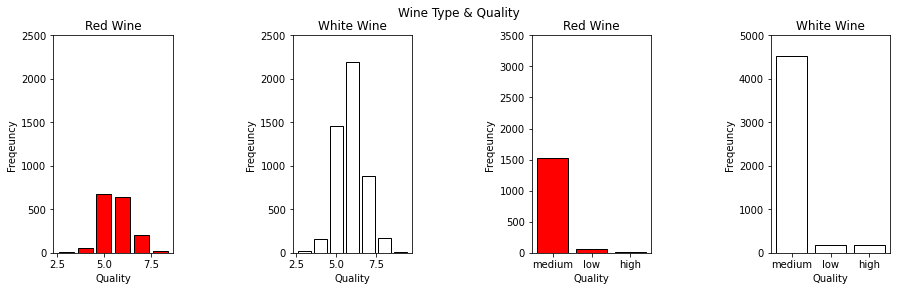

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
fig.suptitle("Wine Type & Quality")
fig.subplots_adjust(wspace=1)

ax[0].set_title("Red Wine")
ax[0].set_xlabel("Quality")
ax[0].set_ylabel("Freqeuncy")
x = db_prepared.quality[db_prepared.type == 'red'].value_counts()
x = (list(x.index), list(x.values))
ax[0].set_ylim([0, 2500])
ax[0].bar(x[0], x[1], color='red', edgecolor='black')

ax[1].set_title("White Wine")
ax[1].set_xlabel("Quality")
ax[1].set_ylabel("Freqeuncy")
x = db_prepared.quality[db_prepared.type == 'white'].value_counts()
x = (list(x.index), list(x.values))
ax[1].set_ylim([0, 2500])
ax[1].bar(x[0], x[1], color='white', edgecolor='black')

ax[2].set_title("Red Wine")
ax[2].set_xlabel("Quality")
ax[2].set_ylabel("Freqeuncy")
x = db_prepared.quality_label[db_prepared.type == 'red'].value_counts()
x = (list(x.index), list(x.values))
ax[2].set_ylim([0, 3500])
ax[2].bar(x[0], x[1], color='red', edgecolor='black')

ax[3].set_title("White Wine")
ax[3].set_xlabel("Quality")
ax[3].set_ylabel("Freqeuncy")
x = db_prepared.quality_label[db_prepared.type == 'white'].value_counts()
x = (list(x.index), list(x.values))
ax[3].set_ylim([0, 5000])
ax[3].bar(x[0], x[1], color='white', edgecolor='black')

plt.show()

Jak widać na wykresie zdecydowana większość win jest średniej jakości.

### Statystyki
Po typie:

In [8]:
red = round(db_prepared.loc[db_prepared.type == 'red', db_prepared.columns].describe(), 2)
white = round(db_prepared.loc[db_prepared.type == 'white', db_prepared.columns].describe(), 2)
type_table = pd.concat([red, white], axis=0, keys=['Red Wine', 'White Wine']).T
print(type_table)

                     Red Wine                                           \
                        count   mean    std   min    25%    50%    75%   
fixed acidity          1599.0   8.32   1.74  4.60   7.10   7.90   9.20   
volatile acidity       1599.0   0.53   0.18  0.12   0.39   0.52   0.64   
citric acid            1599.0   0.27   0.19  0.00   0.09   0.26   0.42   
residual sugar         1599.0   2.54   1.41  0.90   1.90   2.20   2.60   
chlorides              1599.0   0.09   0.05  0.01   0.07   0.08   0.09   
free sulfur dioxide    1599.0  15.87  10.46  1.00   7.00  14.00  21.00   
total sulfur dioxide   1599.0  46.47  32.90  6.00  22.00  38.00  62.00   
density                1599.0   1.00   0.00  0.99   1.00   1.00   1.00   
pH                     1599.0   3.31   0.15  2.74   3.21   3.31   3.40   
sulphates              1599.0   0.66   0.17  0.33   0.55   0.62   0.73   
alcohol                1599.0  10.42   1.07  8.40   9.50  10.20  11.10   
quality                1599.0   5.64  

Po jakości:

In [9]:
low = round(db_prepared.loc[db_prepared.quality_label == 'low', db_prepared.columns].describe(), 2)
medium = round(db_prepared.loc[db_prepared.quality_label == 'medium', db_prepared.columns].describe(), 2)
high = round(db_prepared.loc[db_prepared.quality_label == 'high', db_prepared.columns].describe(), 2)
quality_table = pd.concat([low, medium, high], axis=0, keys=['Low Quality', 'Medium Quality', 'High Quality']).T
print(quality_table)

                     Low Quality                                              \
                           count    mean    std   min    25%     50%     75%   
fixed acidity              246.0    7.36   1.34  4.20   6.50    7.10    8.07   
volatile acidity           246.0    0.47   0.25  0.11   0.28    0.38    0.61   
citric acid                246.0    0.27   0.18  0.00   0.14    0.27    0.38   
residual sugar             246.0    4.27   3.94  0.70   1.50    2.20    5.60   
chlorides                  246.0    0.06   0.05  0.01   0.04    0.05    0.07   
free sulfur dioxide        246.0   22.90  27.85  3.00   7.00   15.00   28.75   
total sulfur dioxide       246.0  105.70  69.44  7.00  50.25  102.00  158.50   
density                    246.0    0.99   0.00  0.99   0.99    1.00    1.00   
pH                         246.0    3.23   0.19  2.74   3.09    3.22    3.36   
sulphates                  246.0    0.51   0.16  0.25   0.40    0.49    0.57   
alcohol                    246.0   10.18

Jak widać na statystykach powyżej:
- w winach białych są wyższe wartości `residual sugar` oraz `dioxides`
- w winach czerwonych są wyższe wartości `sulphates`, `fixed acidity`, `volatile acidity`
- czerwone wino ma dwukrotnie więcej `chlorides`
- `chlorides` oraz `volatile acid` są rzadziej obecne w wysokiej jakości winach,
- wartość `free sulfur dioxide` dla win wyższej jakości

### Korelacje
Korelacje między zmiennymi bazowane na jakości wina.

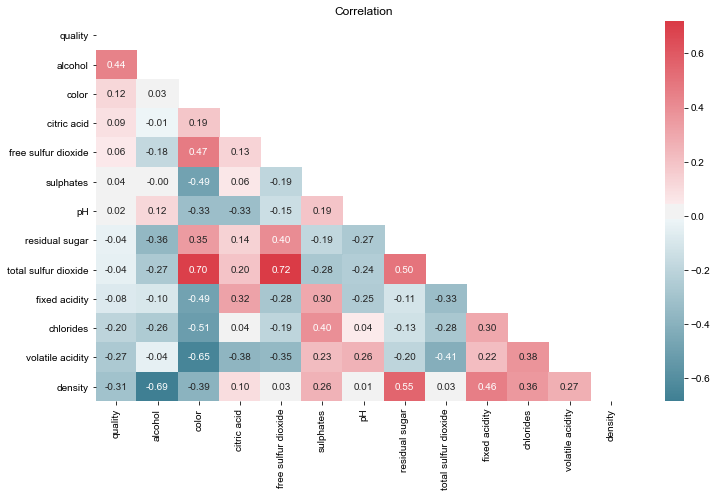

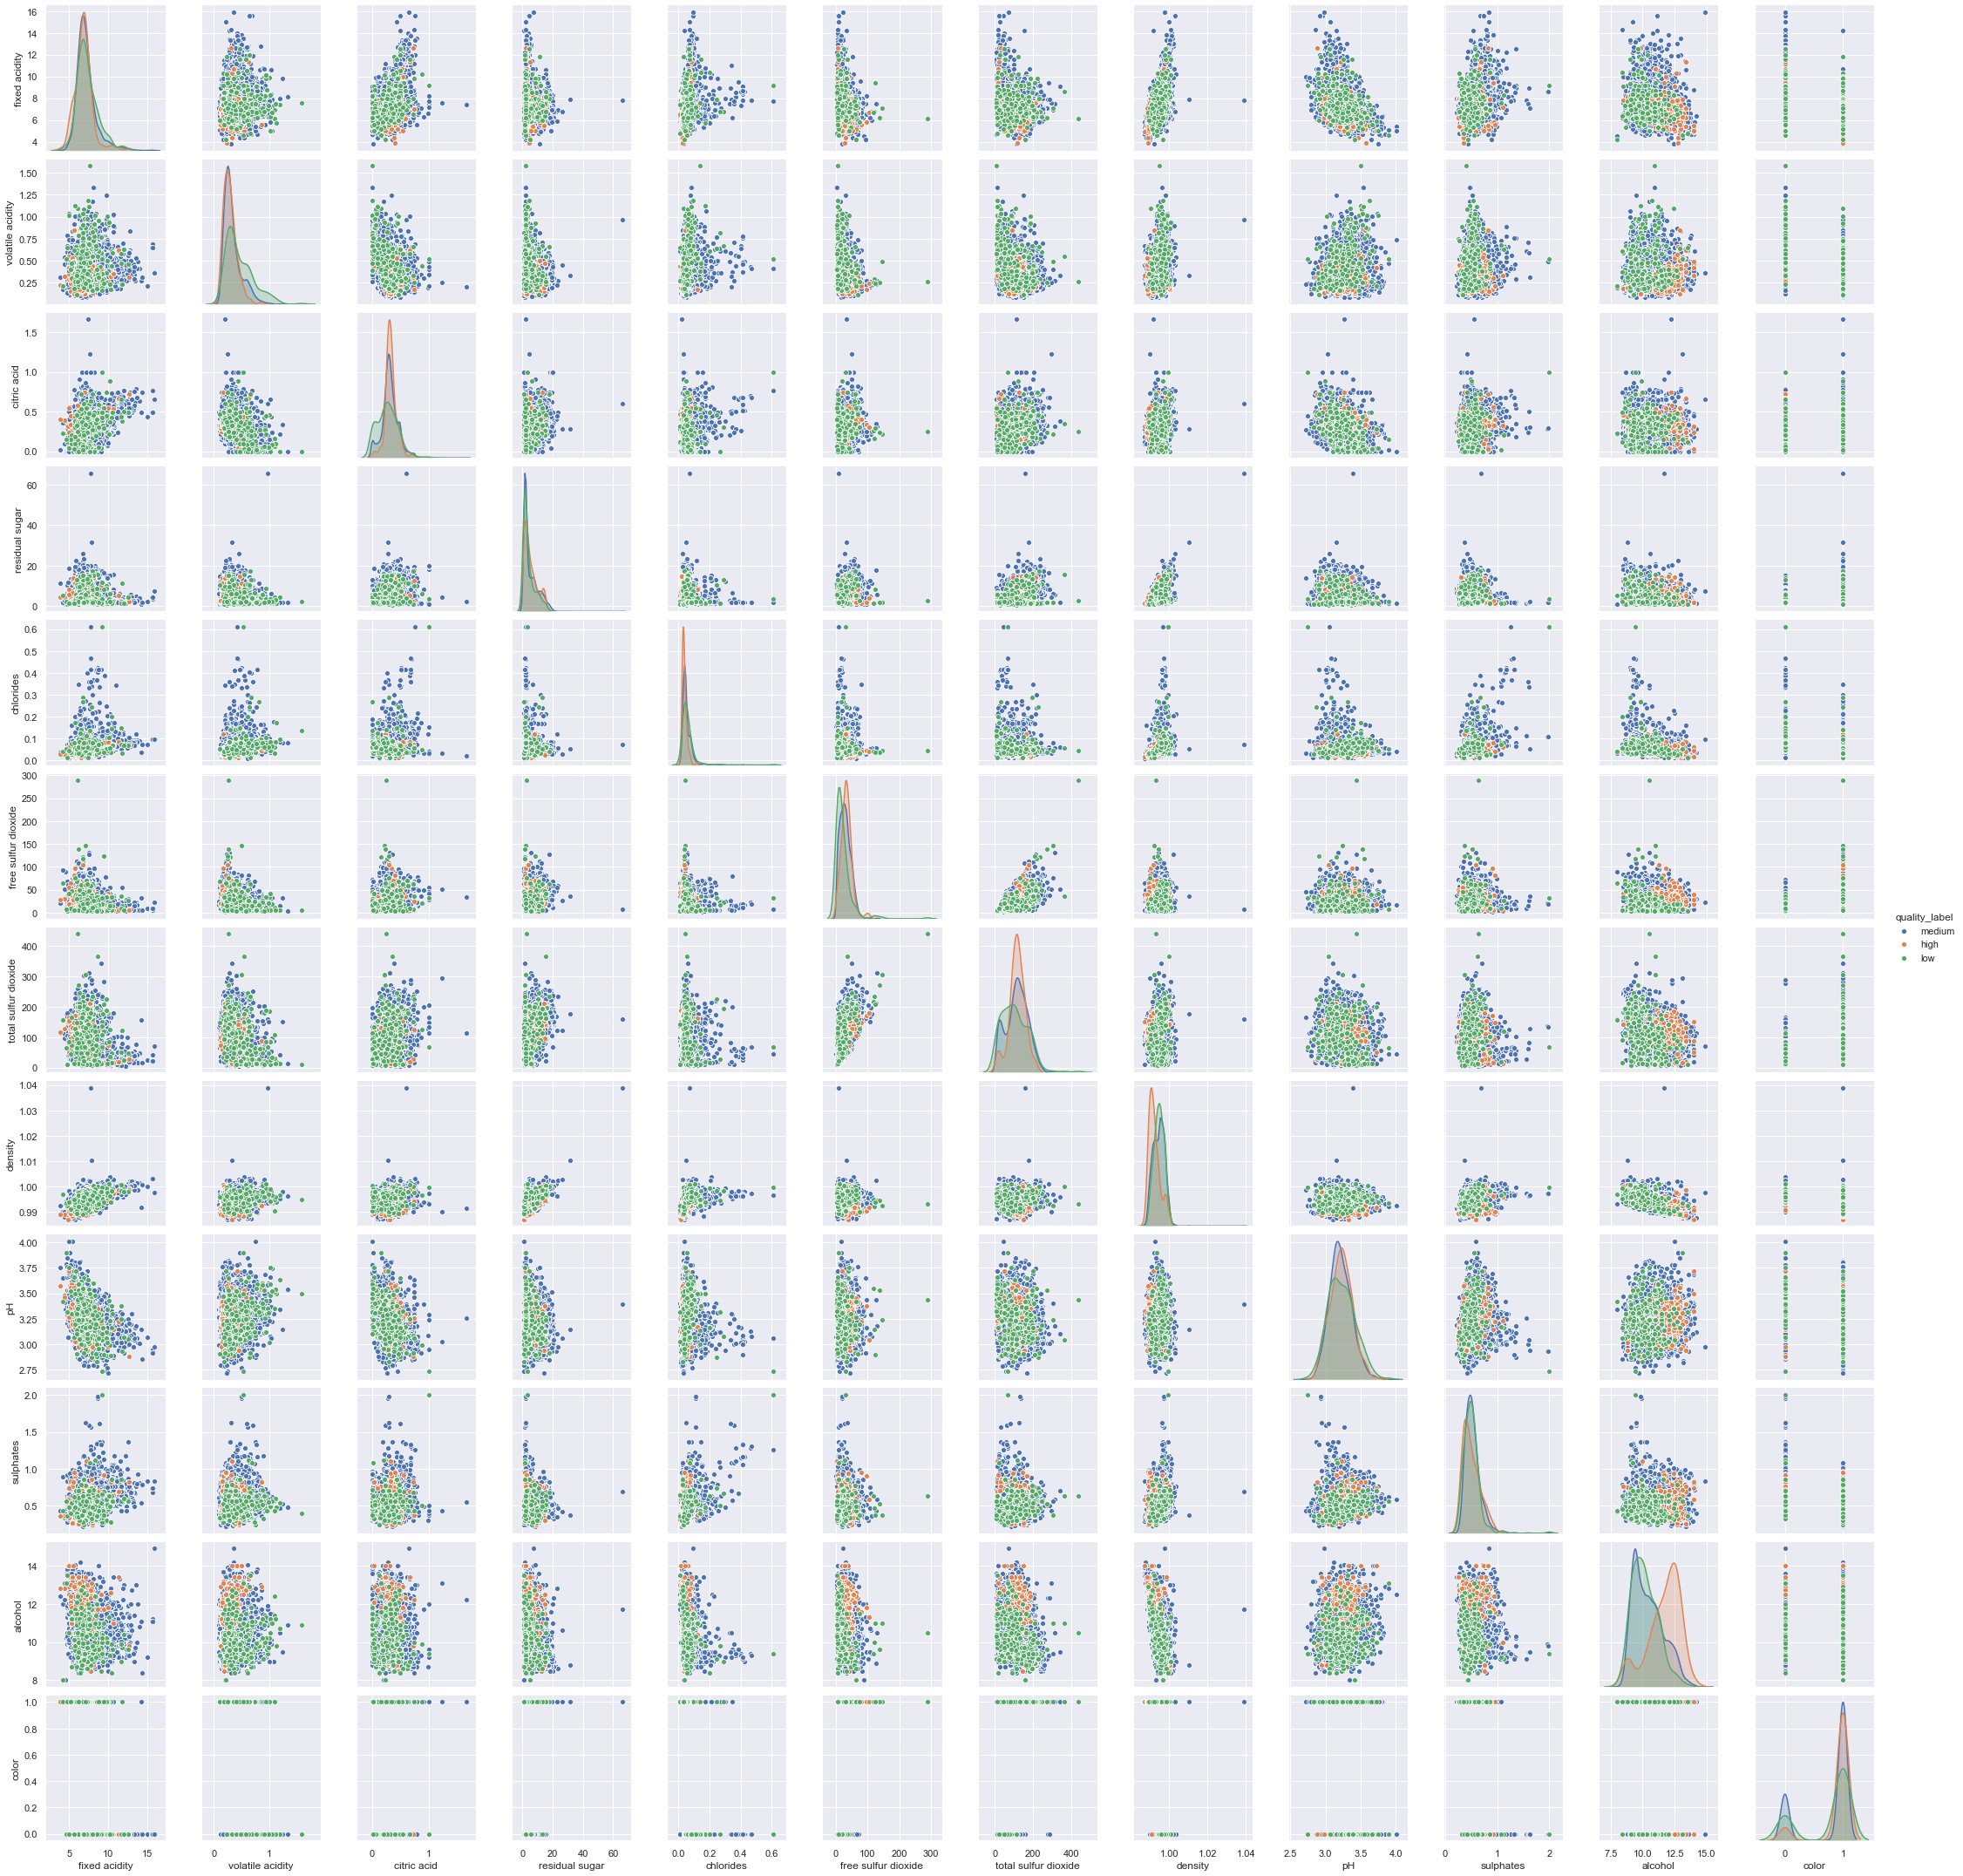

In [10]:
corr = db_prepared.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
drop_self = np.zeros_like(top_corr)
drop_self[np.triu_indices_from(drop_self)] = True
plt.figure(figsize=(12, 7))
plt.title("Correlation")
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f",
            mask=drop_self)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
cols = db_prepared.columns
cols = cols.drop('quality')
g = sns.pairplot(data=db_prepared.loc[:, cols], hue='quality_label')
fig = g.fig
fig.subplots_adjust(top=0.99, wspace=0.3)
plt.show()

Mniejsze wartości `sulphate` w winach wysokiej jakości, ale największe w średniej jakości.
`volatile acidity` ma niską wartość w winach wysokiej jakości.
Największa widoczna korelacja występuje między `total` i `free sulfur dioxide`. Jednak ich korelacja z jakością jest bardzo niska.
Korelacje związane z typem.

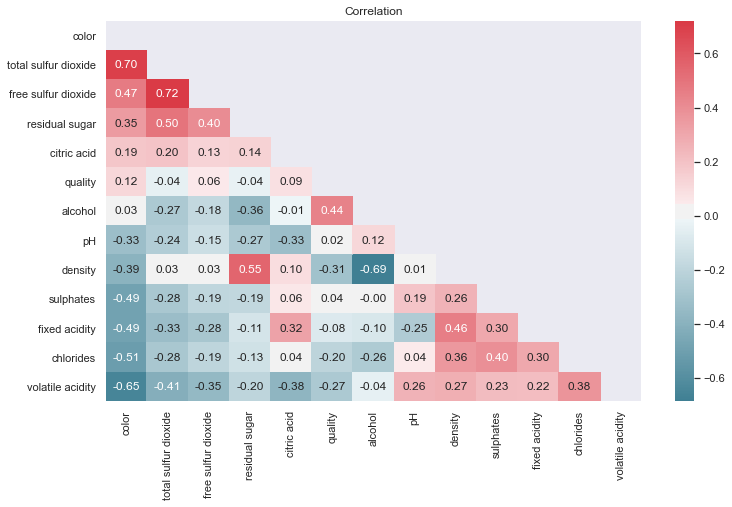

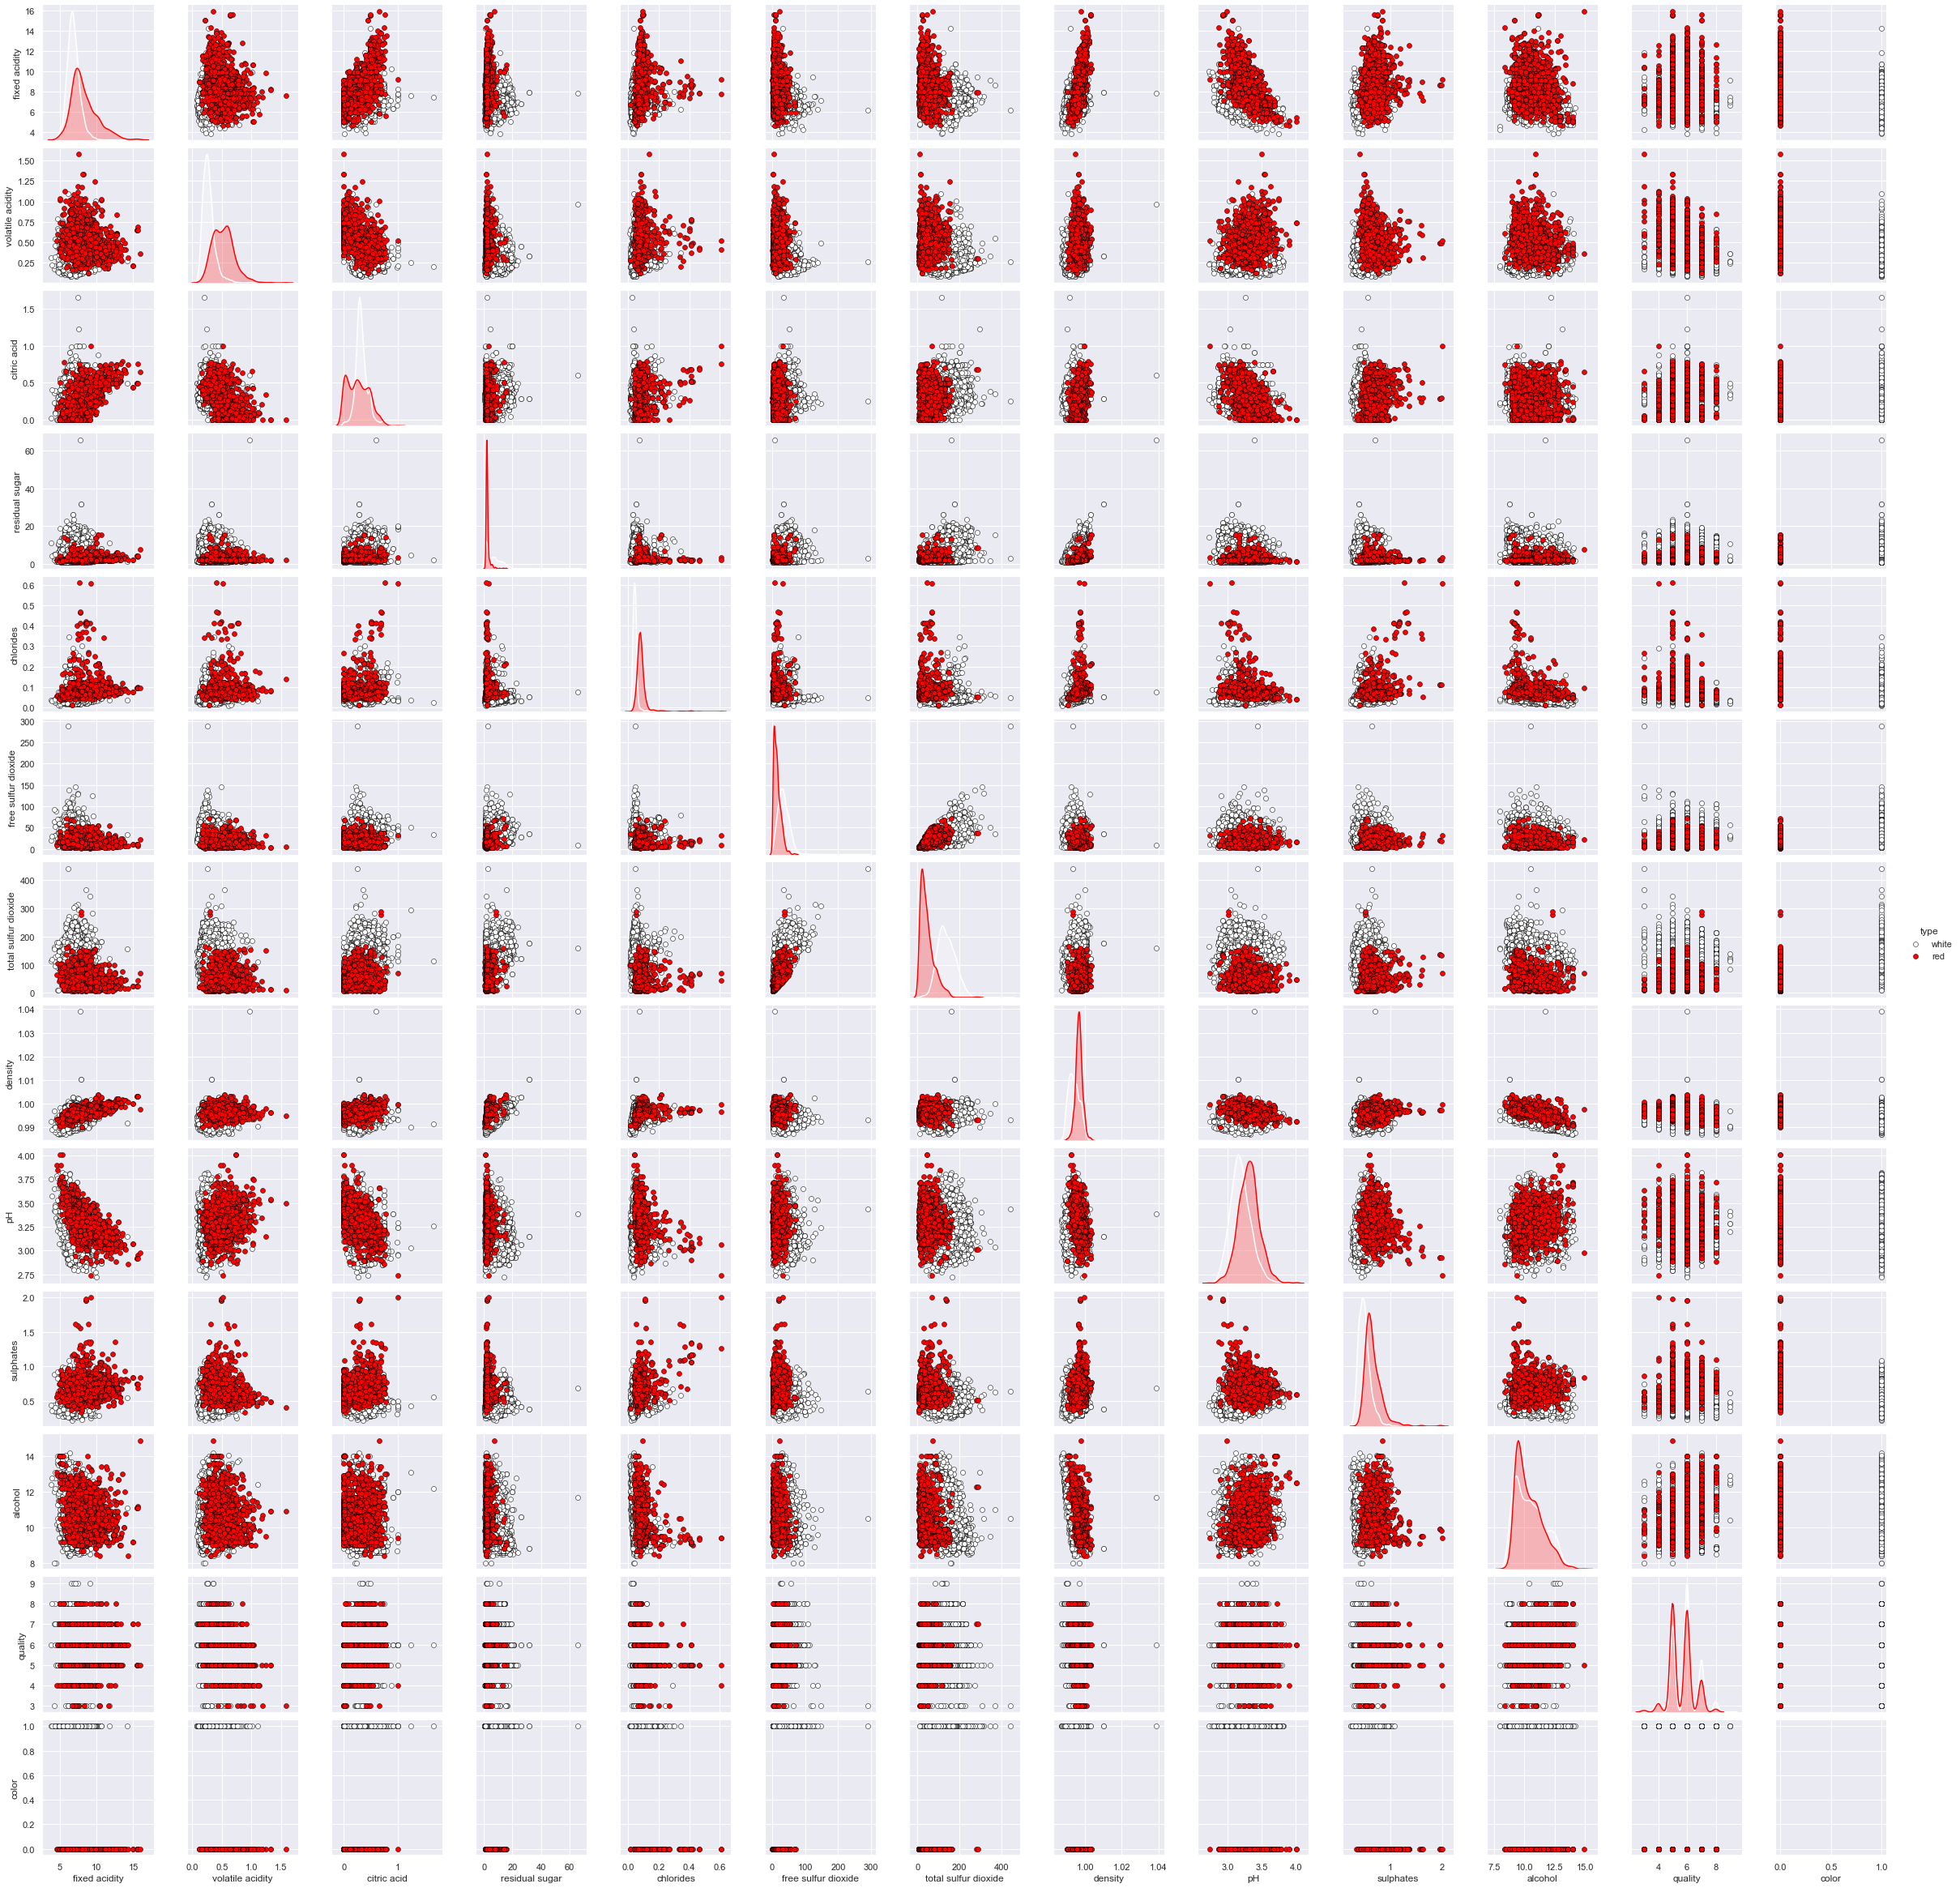

In [11]:
corr = db_prepared.corr()
top_corr_cols = corr.color.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
drop_self = np.zeros_like(top_corr)
drop_self[np.triu_indices_from(drop_self)] = True
plt.figure(figsize=(12, 7))
plt.title("Correlation")
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=drop_self)
sns.set(font_scale=1.5)

sns.set(font_scale=1.0)
g = sns.pairplot(data=db_prepared, hue='type', palette={'red': '#FF0000', 'white': '#FFFFFF'},
                 plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = g.fig
fig.subplots_adjust(top=0.99, wspace=0.3)
plt.show()

`Total (& free) sulfur dioxide` są skorelowane z kolorem wina (w kierunku białego). Korelacje `residual sugar` z `Total (& free) sulfur dioxide` wskazują, że białe wino może mieć więcej cukru niż czerwone.
`Density` ma sporą korelacje z `residual sugar` oraz w przeciwnym kierunku z `alcohol`. `Chlorides` oraz `volatile acidity` są skorelowane z kolorem w kierunku wina czerwonego.

Relacja między jakością a alkoholem

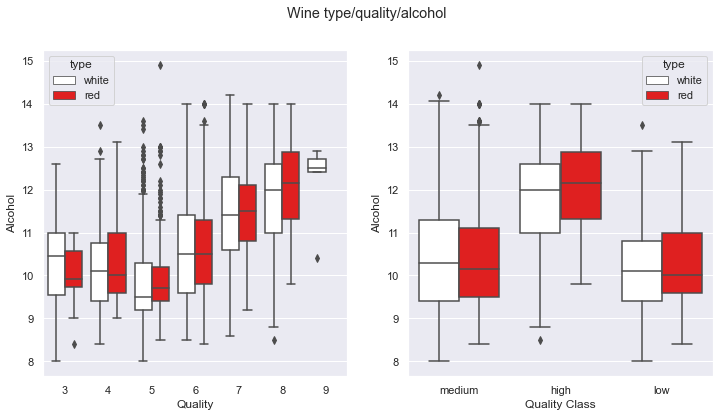

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Wine type/quality/alcohol")
sns.boxplot(x='quality', y='alcohol', hue='type', data=db_prepared, ax=ax[0],
            palette={'red': "#FF0000", 'white': "#FFFFFF"})
ax[0].set_xlabel("Quality")
ax[0].set_ylabel("Alcohol")
sns.boxplot(x='quality_label', y='alcohol', hue='type', data=db_prepared, ax=ax[1],
            palette={'red': "#FF0000", 'white': "#FFFFFF"})
ax[1].set_xlabel("Quality Class")
ax[1].set_ylabel("Alcohol")
plt.show()

Można zauważyć, że od pewnego momentu większa zawartość alkoholu to wyższa jakość.

Relacja między jakością a kwasowością

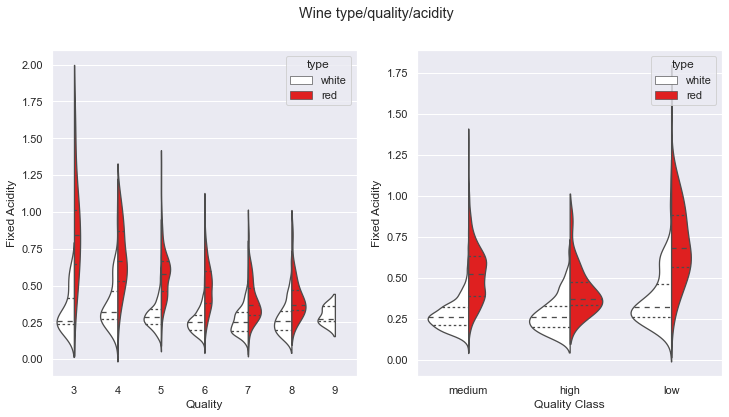

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Wine type/quality/acidity")
sns.violinplot(x='quality', y='volatile acidity', hue='type', data=db_prepared,
               split=True, inner='quart', linewidth=1.3, ax=ax[0],
               palette={'red': "#FF0000", 'white': "#FFFFFF"})

ax[0].set_xlabel("Quality")
ax[0].set_ylabel("Fixed Acidity")
sns.violinplot(x='quality_label', y='volatile acidity', hue='type', data=db_prepared,
               split=True, inner='quart', linewidth=1.3, ax=ax[1],
               palette={'red': "#FF0000", 'white': "#FFFFFF"})
ax[1].set_xlabel("Quality Class")
ax[1].set_ylabel("Fixed Acidity")
plt.show()

Czerwone wino jest bardziej kwaskowate, ale im mniejsza kwasowość tym wyższa jakość.

Relacje między typem, zawartością alkoholu, jakością i kwasowością oraz relacja między typem, zawartością dwutlenku siarkim jakością i kwasowością.

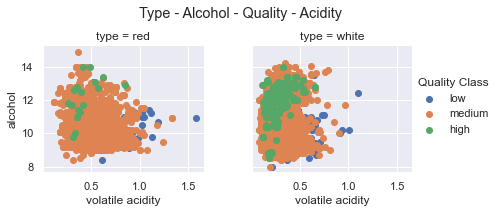

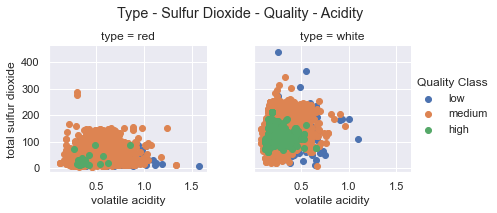

In [14]:
g = sns.FacetGrid(db_prepared, col='type', hue='quality_label',
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'])
g.map(plt.scatter, 'volatile acidity', 'alcohol')
fig = g.fig
fig.subplots_adjust(wspace=0.3, top=0.8)
fig.suptitle("Type - Alcohol - Quality - Acidity")
g.add_legend(title='Quality Class')

g = sns.FacetGrid(db_prepared, col='type', hue='quality_label',
                  col_order=['red', 'white'], hue_order=['low', 'medium', 'high'])
g.map(plt.scatter, 'volatile acidity', 'total sulfur dioxide')
fig = g.fig
fig.subplots_adjust(wspace=0.3, top=0.8)
fig.suptitle("Type - Sulfur Dioxide - Quality - Acidity")
g.add_legend(title='Quality Class')

plt.show()

Pierwszy wykrez pokazuje, że im wyższa jakość wina, to próbki mają mniej `volatile acidity` oraz więcej alkoholu. Można również zauważyć, że białe wina mają mniej `volatile acidity`.
Na drugim wykresie widzimy, że dla win lepszej jakości `volatile acidity` jest mniejsze, woraz że wino czerwone zawiera mniej dwutlenku siarki a więcej `volatile acidity`.

## Klasyfikator
### Przygotowanie danych
Do klasyfikacji musimy dane odpowiednio prrzygotować, potrzebujemy danych numerycznych, więc w tym celu jakość oraz typ wina zastąpimy liczbami.

In [15]:
db = db_prepared.copy()
db['quality_range'] = db.quality.apply(
    lambda q: 0 if q <= 4 else 1 if q <= 7 else 2)
db['type'] = db.type.apply(lambda q: 0 if q == 'white' else 1)

Następnym krokiem jest wybór odpowiednich kolumn do stworzenia zestawu danych.

In [16]:
X = db[['type', 'alcohol', 'density', 'volatile acidity', 'chlorides',
        'citric acid', 'fixed acidity', 'free sulfur dioxide',
        'total sulfur dioxide', 'sulphates', 'residual sugar', 'pH']]
y = db.quality_range
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=40)

### Dopasowanie danych
Wykorzystana metoda logistycznej regresji.

In [17]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

Wyniki:

In [18]:
print('One-vs-rest', '-' * 35,
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy),
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.92
Accuracy in Test  Group   : 0.93


### Predykcje

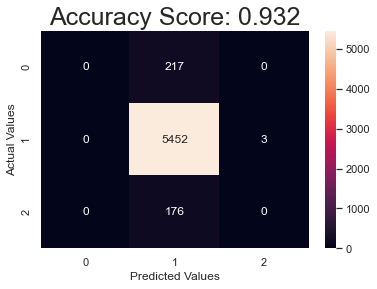

(Total) True Negative       : 0
(Total) True Positive       : 5452
(Total) Negative Positive   : 217
(Total) Negative Negative   : 0
Accuracy Score of Our Model     :  0.9322845417236663
Error rate:  0.06771545827633374


In [19]:
predictions = lr.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=25)
plt.show()

pred_test = lr.predict(X_test)
pred_train = lr.predict(X_train)

quality_pred = LogisticRegression(random_state=40)
quality_pred.fit(X_train, y_train)

confusion_matrix_train = cm(y_train, pred_train)
confusion_matrix_test = cm(y_test, pred_test)

TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) Negative Positive   :", FP)
print("(Total) Negative Negative   :", FN)

print("Accuracy Score of Our Model     : ",  quality_pred.score(X_test, y_test))
Error_Rate = 1 - (accuracy_score(y_test, pred_test))
print("Error rate: ", Error_Rate)

Ostatecznie uzyskany wynik z treningu to trafność: 93.2% oraz błąd 6.8%